In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
def load_dataset(dataset):
    images=[]
    labels=[]

    for subject in range(1,41):
        subject_path=os.path.join(dataset,f's{subject}')
        for image_name in os.listdir(subject_path):
            image_path=os.path.join(subject_path,image_name)
            img=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            images.append(img.flatten())
            labels.append(subject-1)

    return np.array(images),np.array(labels)

In [3]:
dataset_path = '/Users/tej/Desktop/labs/ds/lab4_5/orl_faces' 
X,y=load_dataset(dataset_path)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [5]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print(f"Training set shape: {X_train_std.shape}")
print(f"Testing set shape: {X_test_std.shape}")

Training set shape: (280, 10304)
Testing set shape: (120, 10304)


In [6]:
mean_face = np.mean(X_train_std, axis=0)
X_train_centered = X_train_std - mean_face

In [7]:
cov_matrix=np.cov(X_train_centered, rowvar=False)

In [8]:
eigenvalues,eigenvectors = np.linalg.eigh(cov_matrix)

In [9]:
idx=np.argsort(-eigenvalues)
sorted_eigenvalues=eigenvalues[idx]
sorted_eigenvectors=eigenvectors[:,idx]

In [10]:
eigenfaces=sorted_eigenvectors.T
print(eigenfaces.shape)

(10304, 10304)


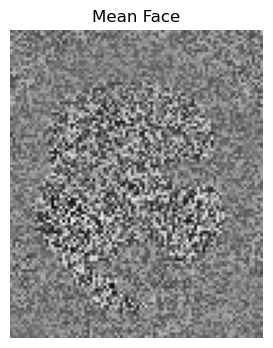

In [11]:
w,h=92,112

plt.figure(figsize=(4, 4))
plt.imshow(mean_face.reshape(h, w), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

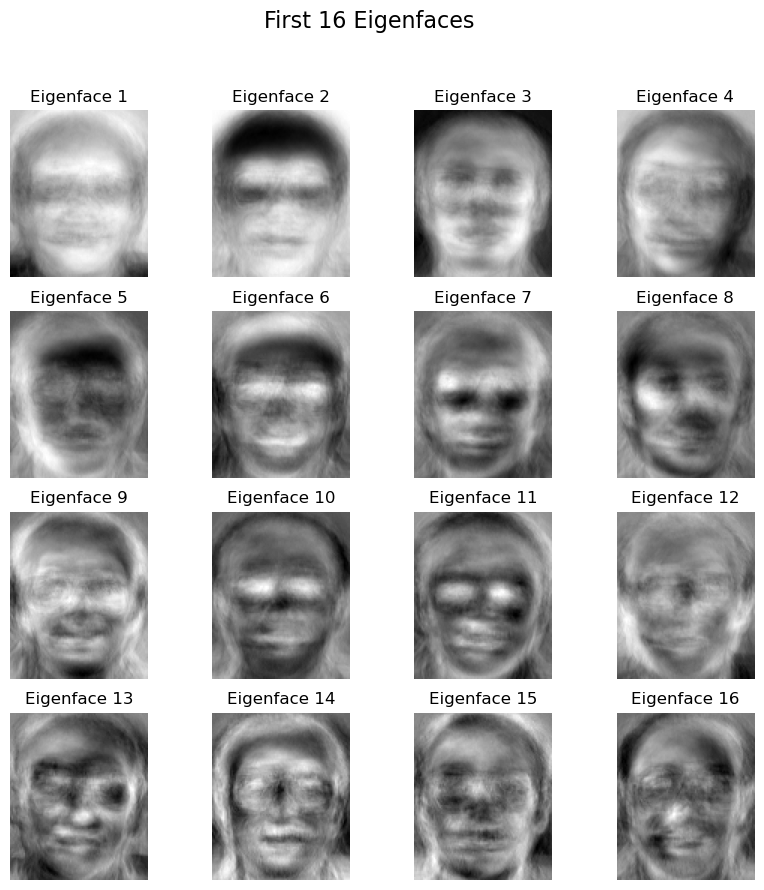

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i].reshape(h, w), cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
plt.suptitle("First 16 Eigenfaces", fontsize=16)
plt.show()

In [13]:
def img_reconstruct(img,mean_img,eigenfaces,k):
    centered_img=img-mean_img
    weights=np.dot(centered_img,eigenfaces[:k,:].T)
    reconstructed_centered=np.dot(weights,eigenfaces[:k,:])
    reconstructed_img=reconstructed_centered+mean_img

    return reconstructed_img

In [14]:
original_image_std = X_test_std[5]
original_image_unscaled = scaler.inverse_transform(original_image_std.reshape(1,-1))

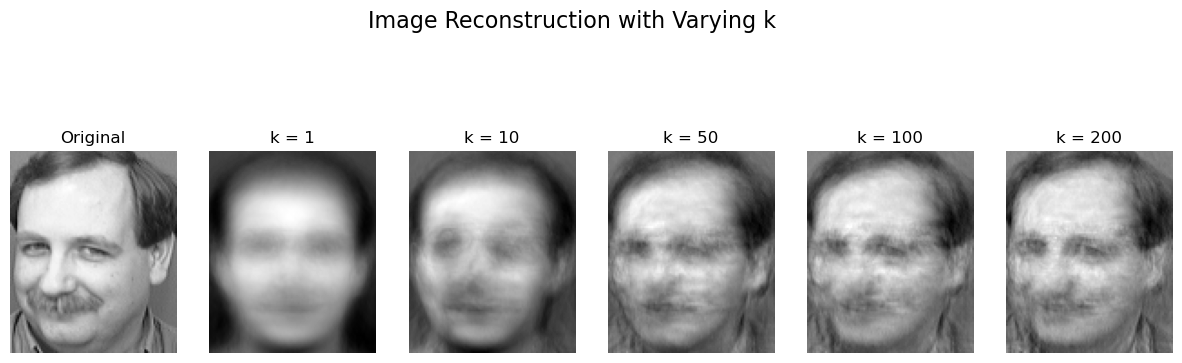

In [15]:
k_values = [1, 10, 50, 100, 200]
reconstructions=[]

for k in k_values:
    r=img_reconstruct(original_image_std,mean_face,eigenfaces,k)
    reconstructions.append(scaler.inverse_transform(r.reshape(1, -1)))

fig, axes = plt.subplots(1, len(k_values) + 1, figsize=(15, 5))
axes[0].imshow(original_image_unscaled.reshape(h, w), cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

for i, k in enumerate(k_values):
    axes[i+1].imshow(reconstructions[i].reshape(h, w), cmap='gray')
    axes[i+1].set_title(f"k = {k}")
    axes[i+1].axis('off')
    
plt.suptitle("Image Reconstruction with Varying k", fontsize=16)
plt.show()


In [20]:
def recognize_face(test_image_std, X_train_std, y_train, mean_face, eigenfaces, k):
    X_train_centered = X_train_std - mean_face
    X_train_pca = np.dot(X_train_centered, eigenfaces[:k, :].T)
    
    test_image_centered = test_image_std - mean_face
    test_image_pca = np.dot(test_image_centered, eigenfaces[:k, :].T)
    
    distances = np.linalg.norm(X_train_pca - test_image_pca, axis=1)
    closest_match_index = np.argmin(distances)
    
    return y_train[closest_match_index]

Accuracy for k=1: 0.0917
Accuracy for k=5: 0.8417
Accuracy for k=10: 0.9167
Accuracy for k=20: 0.9250
Accuracy for k=30: 0.9417
Accuracy for k=40: 0.9417
Accuracy for k=50: 0.9417
Accuracy for k=75: 0.9333
Accuracy for k=100: 0.9583
Accuracy for k=150: 0.9417
Accuracy for k=200: 0.9417


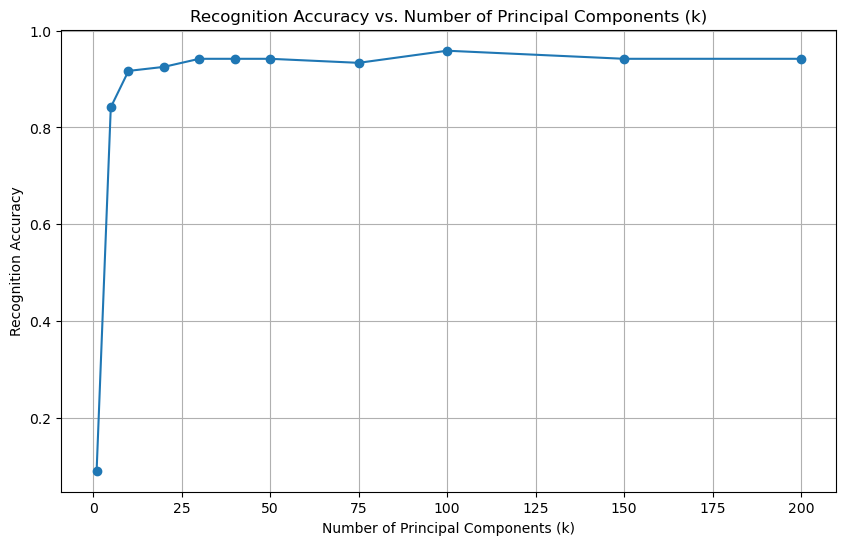

In [22]:
k_values_for_accuracy = [1, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200]
accuracies = []

for k in k_values_for_accuracy:
    correct_predictions = 0
    for i in range(len(X_test_std)):
        predicted_label = recognize_face(
            X_test_std[i], X_train_std, y_train, mean_face, eigenfaces, k
        )
        if predicted_label == y_test[i]:
            correct_predictions += 1
            
    accuracy = correct_predictions / len(X_test)
    accuracies.append(accuracy)
    print(f"Accuracy for k={k}: {accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values_for_accuracy, accuracies, marker='o', linestyle='-')
plt.title("Recognition Accuracy vs. Number of Principal Components (k)")
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Recognition Accuracy")
plt.grid(True)
plt.show()

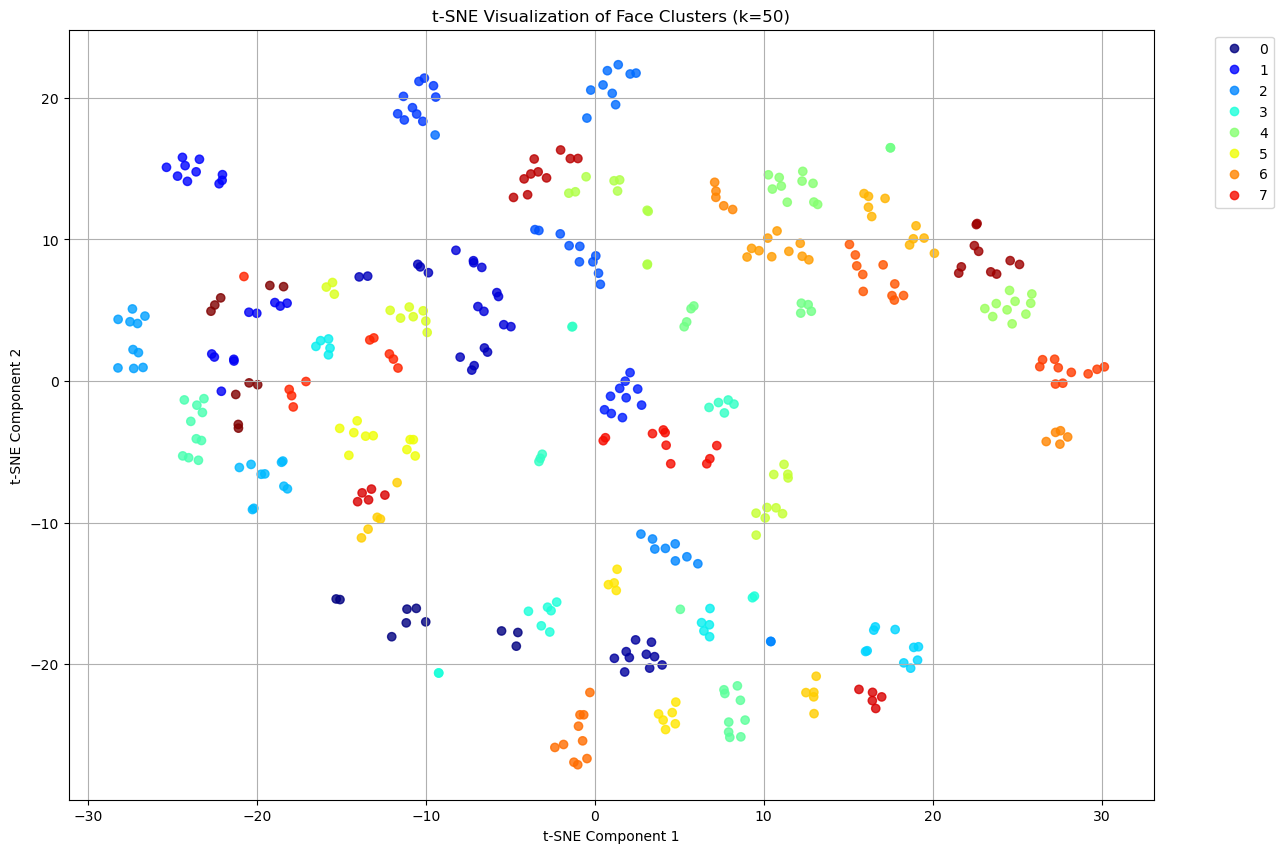

In [24]:
k_tsne = 50

X_std = scaler.transform(X) 
X_centered = X_std - mean_face
X_pca = np.dot(X_centered, eigenfaces[:k_tsne, :].T)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(X_pca)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    c=y, 
    cmap=plt.get_cmap('jet', 40),
    alpha=0.8
)
plt.title(f't-SNE Visualization of Face Clusters (k={k_tsne})')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(40), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()